# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом по классификации emoji из тг. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 100 классов и около 100 картинок на каждый класс. Классы пронумерованы, кодом смайлика к которому относятся элементы класса. Скачать датасет можно вот [тут](https://disk.yandex.ru/d/elNF0DS94o2GVA).

Структура датасета -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.4**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 20 баллов

2) Добейтесь accuracy **на валидации не менее 0.8**. В этом задании делать ресайз и использовать претрейн можно. 20 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(20, 20 * Ваша accuracy / 0.4)` для первого задания и `min(20, 20 * (Ваша accuracy - 0.4) / 0.4)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [ ]:
# !pip install wandb
# !pip3 install pytorch_lightning torchmetrics

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из семинара 5.

In [1]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wrl (super_mega_haip_team). Use `wandb login --relogin` to force relogin


True

In [9]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
import torchmetrics.functional as metrics
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.tuner import Tuner
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

import torchvision.models as models
device = 'cuda'


In [2]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(11)

## Задание 0

### Что поможет сделать на 100%

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать свою модель руками в классе YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [49]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Аугментация: случайное горизонтальное отражение
    transforms.RandomRotation(degrees=20),  # Случайный поворот на ±15 градусов
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Нормализация
])

val_transform = transforms.Compose([
    
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Нормализация
])


train_dataset = ImageFolder('./dataset/train', transform=train_transform)
val_dataset = ImageFolder('./dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

при нормализации ругается на значения

In [4]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].


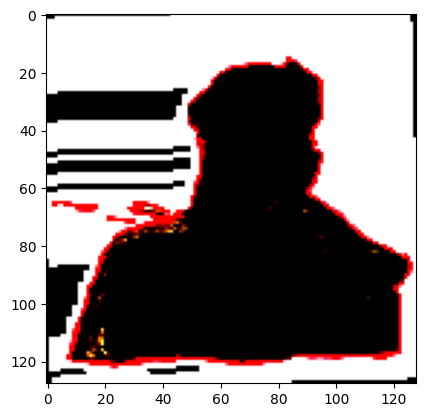

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].


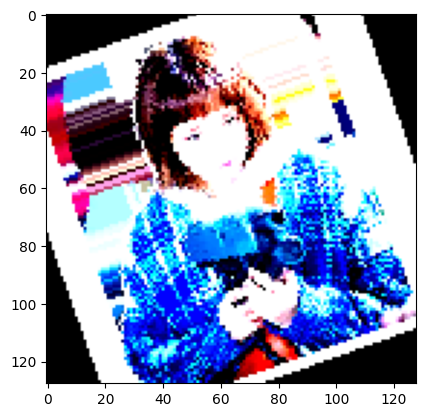

In [6]:
for batch in train_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

20 баллов.  
Добейтесь accuracy на валидации не менее 0.4. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 10/20 баллов (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть ноутбуки прошедших семинаров и создайте из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
class ZeroNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*29*29, 128)
        self.fc2 = nn.Linear(128, 100)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def xward(self, x):

        pred = self.conv1(x)
        pred = self.relu(pred)
        pred = self.pool(pred)

        pred = self.conv2(pred)
        pred = self.relu(pred)
        pred = self.pool(pred)
        
        pred = self.flatten(pred)
        pred = self.fc1(pred)
        pred = self.relu(pred)
        pred = self.fc2(pred)

        return pred
    
    def forward(self, images, target=None):

        output = self.xward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy_value = metrics.accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=100)

        return loss if target is not None else output


    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy_value

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        
        
        # Глобальное усреднение вместо flatten
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Полносвязные слои с Dropout для регуляризации
        self.fc = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Регуляризация
            nn.Linear(128, 100)
        )

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, 100)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def xward(self, x):
        
        pred = self.vgg(x)
        pred = self.global_avg_pool(pred)  # Уменьшаем размерность до (Batch, Channels, 1, 1)
        pred = pred.view(pred.size(0), -1)  # Преобразуем в (Batch, Channels)
        pred = self.fc(pred)  # Пропускаем через FC слои
        return pred
        
    
    def forward(self, images, target=None):
        output = self.xward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy_value = metrics.accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=100)

        return loss if target is not None else output


    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy_value

In [19]:
dense_model = models.densenet121(weights=None) # импорт модели без весов
fc_out = nn.Linear(dense_model.classifier.in_features, 100) 
dense_model.classifier = fc_out # изменение слоя-классификатора

### Тренировочный класс lightning

In [20]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate = 0.001):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate        


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch

        preds = self(images)
        pred_class = torch.argmax(preds, dim=-1)
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)  
        self.accuracy_value = metrics.accuracy(pred_class, target, task='multiclass', num_classes=100)

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self(images)
        pred_class = torch.argmax(preds, dim=-1)
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)
        self.accuracy_value = metrics.accuracy(pred_class, target, task='multiclass', num_classes=100)


    def get_accuracy(self):
        
        return self.accuracy_value


In [39]:
class DenseModule(pl.LightningModule):
    def __init__(self, model, learning_rate = 0.001):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate     
        self.loss_func = nn.CrossEntropyLoss()   


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch

        preds = self.model(images)
        loss = self.loss_func(preds, target)
        pred_class = torch.argmax(preds, dim=-1)

        self.log("train_loss", loss, prog_bar=True)  
        self.accuracy_value = metrics.accuracy(pred_class, target, task='multiclass', num_classes=100)

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.model(images)
        loss = self.loss_func(preds, target)
        pred_class = torch.argmax(preds, dim=-1)
        self.log("val_loss", loss, prog_bar=True)
        self.accuracy_value = metrics.accuracy(pred_class, target, task='multiclass', num_classes=100)


    def get_accuracy(self):
        return self.accuracy_value


In [14]:

my_model = ZeroNet().to(device) 
module = YourModule(my_model, learning_rate=0.0005)

In [ ]:
trainer = pl.Trainer(accelerator="gpu", max_epochs=5, default_root_dir="D:/ai")
trainer.fit(module, train_dataloader, val_dataloader)

In [11]:
torch.save(my_model.state_dict(), "zeromodel.pth")

In [7]:
i = 8

In [ ]:
NetModel = Net().to(device)
trainer = pl.Trainer(accelerator="gpu", max_epochs=10, default_root_dir="D:/ai", limit_train_batches=0.3)

NetModule = YourModule(NetModel)

trainer.fit(NetModule, train_dataloader, val_dataloader)
dir_name = "./versions/netmodel/netmodel_version_"+str(i)+".pt"

torch.save(NetModel.state_dict(), dir_name)
i+=1


In [40]:
dense_module = DenseModule(dense_model, learning_rate=0.01)

In [41]:
trainer = pl.Trainer(max_epochs=2, default_root_dir="./dense", limit_train_batches=0.2)
trainer.fit(dense_module, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | DenseNet         | 7.1 M  | eval 
1 | loss_func | CrossEntropyLoss | 0      | train
-------------------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.225    Total estimated model params size (MB)
1         Modules in train mode
433       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\a.z\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\a.z\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


### Валидация результатов задания

In [56]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy_metric = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            # predicts = model(images).argmax(dim=1)
            # #loss = model(images, labels)
            # acc_batch = model.get_accuracy()
            # correct += acc_batch
            preds = model(images)
            predicted = preds.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
    accuracy_metric = correct / total
    #print(correct, len(test_dataloader), total)
    return accuracy_metric

In [60]:
model_test = ZeroNet().to(device)
model_test.load_state_dict(torch.load('zeromodel.pth', weights_only=True))

accuracy = evaluate_task(model_test, val_dataloader)
print(f"Оценка за это задание составит {np.clip(20 * accuracy / 0.4, 0, 20):.2f} баллов")

100%|██████████| 79/79 [00:03<00:00, 24.84it/s]

Оценка за это задание составит 8.52 баллов


In [15]:
import winsound
frequency = 1500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)



In [50]:
from pathlib import Path


path = Path("D:/ai/lightning_logs/version_56/checkpoints") / "epoch=9-step=4270.ckpt"

loaded_model = torch.load(path, weights_only=True)
model_weights = loaded_model["state_dict"]
for key in list(model_weights):
    model_weights[key.replace("model.", "")] = model_weights.pop(key)


NetModel.load_state_dict(model_weights)

acc = evaluate_task(NetModule, val_dataloader, device=device)
print(acc)
print(f"Оценка за это задание составит {np.clip(20 * acc / 0.4, 0, 20):.2f} баллов")


100%|██████████| 79/79 [00:03<00:00, 21.16it/s]

266 79 2500
3.367088607594937
Оценка за это задание составит 20.00 баллов


In [ ]:
# model = Net().to(device)
# NetModel.load_state_dict(torch.load('./versions/netmodel/netmodel_version_15.pt', weights_only=True))
# model_1 = NetModel

checkpoint = "D:/ai/lightning_logs/version_53/checkpoints/epoch=4-step=7130.ckpt"
model = YourModule.load_from_checkpoint(checkpoint, model = NetModel)

# model_22 = model.model


NetAccuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(20 * NetAccuracy / 0.4, 0, 20):.2f} баллов")
print(NetAccuracy)
winsound.Beep(frequency, duration)


In [53]:
torch.save(dense_model.state_dict(), "./dense/save")

In [55]:
dense_model_test = models.densenet121()
dense_model_test.classifier = nn.Linear(dense_model_test.classifier.in_features, 100)
dense_model_test.load_state_dict(torch.load("./dense/save"))

C:\Temp\ipykernel_19976\2056670781.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dense_model_test.load_state_dict(torch.load("./dense/save"))


<All keys matched successfully>

In [57]:
Accuracy = evaluate_task(dense_model_test, val_dataloader)
print(f"Оценка за это задание составит {np.clip(20 * Accuracy / 0.4, 0, 20):.2f} баллов")
print(Accuracy)

100%|██████████| 79/79 [00:06<00:00, 11.83it/s]

Оценка за это задание составит 6.80 баллов
0.136


## Задание 2

20 баллов
Добейтесь accuracy на валидации не менее 0.8. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 10/20 баллов (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры лучше используйте Adam c параметрами по умолчанию как стартовую точку.
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и создайте из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [61]:
Dense_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
Dense_model.classifier = nn.Linear(Dense_model.classifier.in_features, 100)
Dense_model.train()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        # YOUR CODE HERE
        pass

    def forward(self, x):
        # YOUR CODE HERE
        pass

    def configure_optimizers(self):
        # YOUR CODE HERE
        pass

    def training_step(self, train_batch, batch_idx):
        # YOUR CODE HERE
        pass

    def validation_step(self, val_batch, batch_idx):
        # YOUR CODE HERE
        pass

In [62]:
module = DenseModule(Dense_model, learning_rate=0.001)

In [63]:
trainer = pl.Trainer(max_epochs=2, default_root_dir="./dense/predtrain", limit_train_batches=0.2)
trainer.fit(module, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | DenseNet         | 7.1 M  | train
1 | loss_func | CrossEntropyLoss | 0      | train
-------------------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.225    Total estimated model params size (MB)
434       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\a.z\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\a.z\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [64]:
torch.save(Dense_model.state_dict(), "./dense/predtrain/model")

### Валидация результатов задания

In [67]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 100)
model.load_state_dict(torch.load("./dense/predtrain/model"))

accuracy_m = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(20 * (accuracy_m - 0.4) / 0.4, 0, 20):.2f} баллов")

C:\Temp\ipykernel_19976\3946670985.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./dense/predtrain/model"))
100%|██████████| 79/79 [0

Оценка за это задание составит 0.00 баллов


## Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

https://qudata.com/ml/ru/NN_CNN_Intro.html 

https://qudata.com/ml/ru/NN_Base_Torch_NN_Ref.html

https://neurohive.io/ru/tutorial/cnn-na-pytorch/

https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling

https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch
